In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from keras import backend as K
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Conv1D,Input,Flatten, MaxPooling1D, BatchNormalization,Dropout,GlobalAveragePooling1D, AveragePooling1D, Conv2D, AveragePooling2D



2024-08-24 19:20:43.879317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 19:20:44.922850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
arqs_train = os.listdir('../scr/train')
arqs_test = os.listdir('../scr/test')

n_points = 50

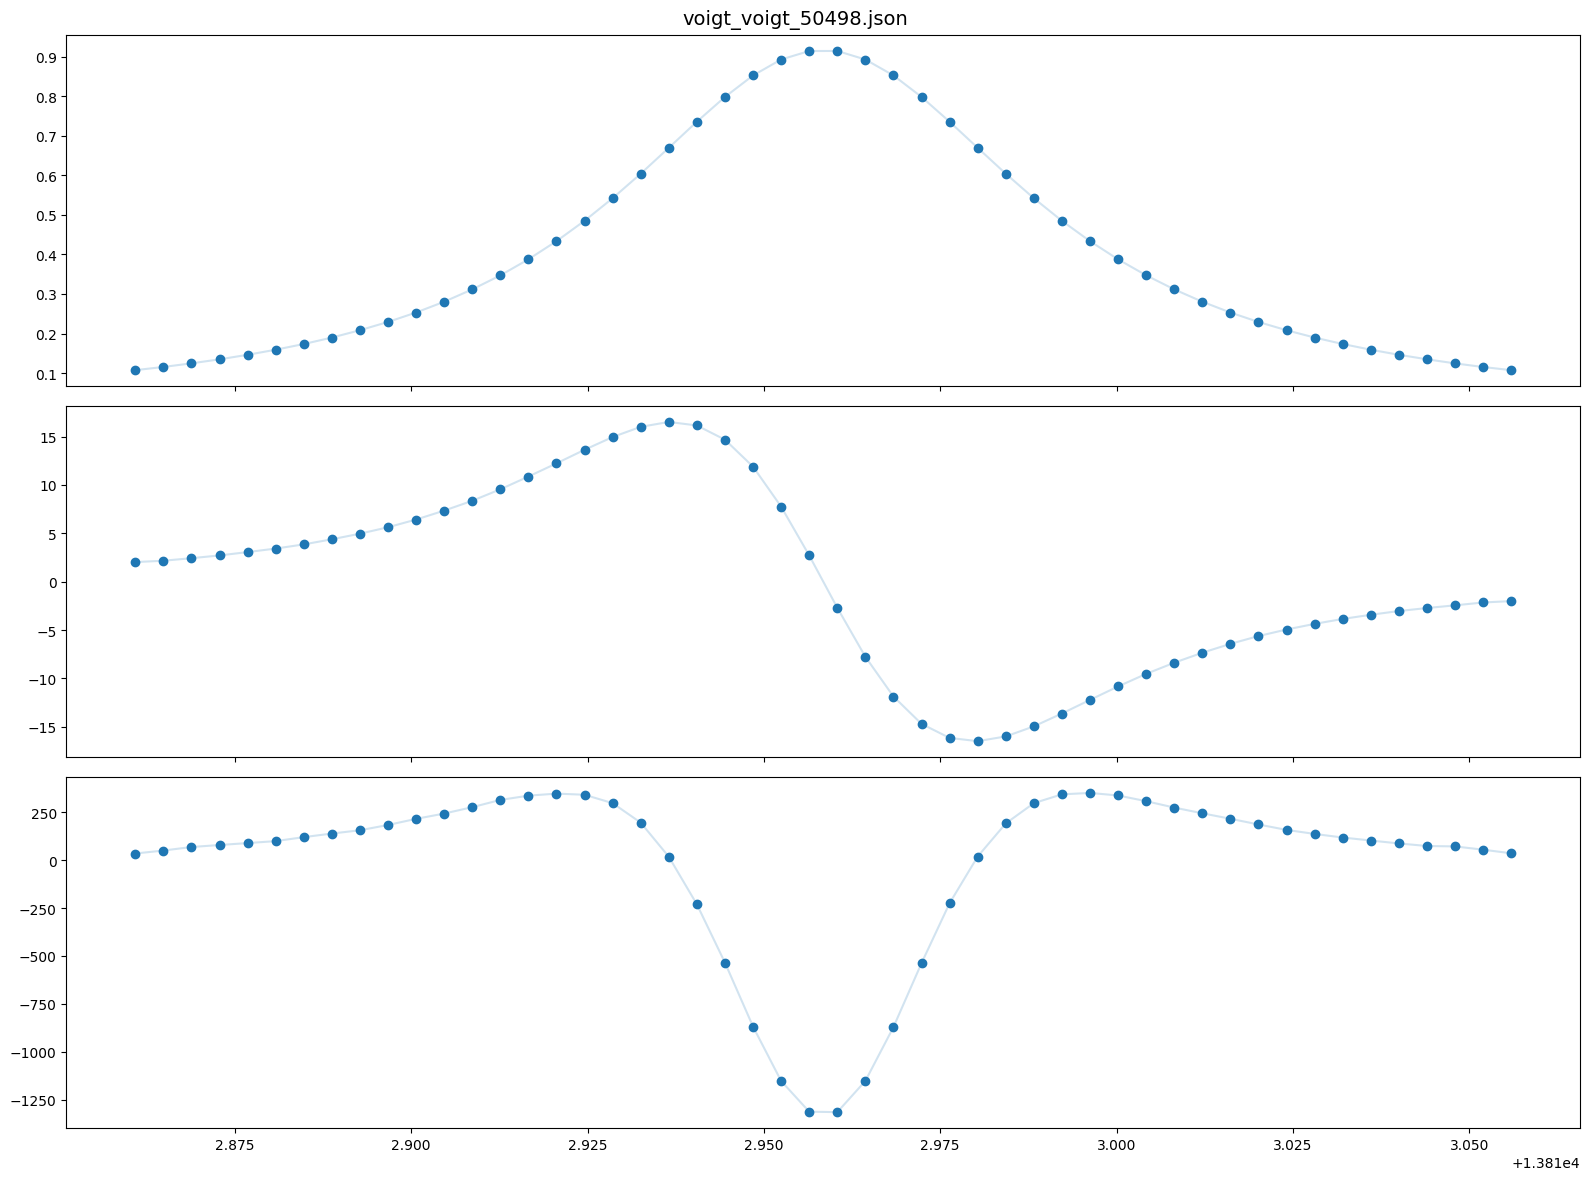

In [3]:
data = np.random.choice(arqs_train)
with open(f'../scr/train/{data}','r') as json_file:
    file = json.load(json_file)


wavenumber = file['x']
line = file['y']
d1 = file['primeira_derivada']
d2 = file['segunda_derivada']

fig , ax = plt.subplots(3,1,tight_layout=True,sharex=True, figsize=(16,12))

fig.suptitle(data.split('_')[0]+ f'_{data}',size=14)
ax[0].scatter(x=wavenumber,y= line)
ax[0].plot(wavenumber,line,alpha=0.2)
ax[1].scatter(x=wavenumber,y= d1)
ax[1].plot(wavenumber,d1,alpha=0.2)
ax[2].scatter(x=wavenumber,y= d2)
ax[2].plot(wavenumber,d2,alpha=0.2)

In [4]:
X_train = []
y_train = []
ysigma_train = []
ygamma_train = []
statistics_train = []
for arq in arqs_train:
    with open(f'../scr/train/{arq}','r') as file:
        d = json.load(file)

    s =  np.array(d['y']).reshape((n_points,1))
    d1 = np.array(d['primeira_derivada']).reshape((n_points,1))
    d2 = np.array(d['segunda_derivada']).reshape((n_points,1))
    X_train.append(np.concatenate([s,d1,d2],axis=1).reshape((n_points,3)))
    statistics_train.append(list(d['statistics'].values()))

    y = d['curve_type']
    if y == "gaussian":
        y_target = 0
    elif y == 'lorentz':
        y_target = 1
    else:
        y_target = 2
            
    y_train.append(y_target)
    ysigma_train.append(d['sigma'])
    ygamma_train.append(d['gamma'])


X_test = []
y_test = []
ysigma_test = []
ygamma_test = []
statistics_test = []
for arq in arqs_test:
    with open(f'../scr/test/{arq}','r') as file:
        d = json.load(file)
        
    s =  np.array(d['y']).reshape((n_points,1))
    d1 = np.array(d['primeira_derivada']).reshape((n_points,1))
    d2 = np.array(d['segunda_derivada']).reshape((n_points,1))
    X_test.append(np.concatenate([s,d1,d2],axis=1).reshape((n_points, 3)))
    statistics_test.append(list(d['statistics'].values()))

    y = d['curve_type']
    if y == "gaussian":
        y_target = 0
    elif y == 'lorentz':
        y_target = 1
    else:
        y_target = 2
            
    y_test.append(y_target)
    ysigma_test.append(d['sigma'])
    ygamma_test.append(d['gamma'])


X_train  =  tf.convert_to_tensor(X_train)
X_test   =  tf.convert_to_tensor(X_test)

y_train  = tf.convert_to_tensor(y_train)
y_test   = tf.convert_to_tensor(y_test)

ysigma_train = tf.convert_to_tensor(ysigma_train)
ysigma_test  = tf.convert_to_tensor(ysigma_test)

ygamma_train = tf.convert_to_tensor(ygamma_train)
ygamma_test  = tf.convert_to_tensor(ygamma_test)

y_train  = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test   = tf.keras.utils.to_categorical(y_test , num_classes=3)

statistics_train = tf.convert_to_tensor(statistics_train)
statistics_test = tf.convert_to_tensor(statistics_test)

2024-08-24 19:21:17.967380: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 216000000 exceeds 10% of free system memory.


In [5]:
input = Input(shape=(50,3),name='input')
x = Conv1D(126, 15, strides=1, padding='same', activation='tanh')(input)
#x = Conv1D(126, 32, strides=1, padding='same', activation='elu')(x)
x = AveragePooling1D(pool_size=4,padding='same')(x)
x = BatchNormalization()(x)

x = Conv1D(32, 10 , strides=1, padding='same', activation='tanh')(x)
x = Conv1D(32, 10 , strides=1, padding='same', activation='tanh')(x)
x = Conv1D(32, 10 , strides=1, padding='same', activation='tanh')(x)
x = AveragePooling1D(pool_size=3,padding='same')(x)
x = BatchNormalization()(x)

x = Conv1D(16, 5, strides=1, padding='same', activation='tanh')(x)
x = Conv1D(16, 5, strides=1, padding='same', activation='tanh')(x)
x = Conv1D(16, 5, strides=1, padding='same', activation='tanh')(x)
x = AveragePooling1D(pool_size=2,padding='same')(x)
x = BatchNormalization()(x)

x = Conv1D(8, 3, strides=1, padding='same', activation='tanh')(x)
x = Conv1D(8, 3, strides=1, padding='same', activation='tanh')(x)
x = Conv1D(8, 3, strides=1, padding='same', activation='tanh')(x)
x = AveragePooling1D(pool_size=2,padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)



# Entrada 2: Estatísticas
input_statistics = Input(shape=(12,),name='input_statistics')
x_s = BatchNormalization()(input_statistics)
x_s = Dense(16, activation='relu')(x_s)
x_s = Dense(8, activation='relu')(x_s)



#x = GlobalAveragePooling1D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.05)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.05)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.05)(x)
x = Dense(64,activation='relu')(x)

merged = tf.keras.layers.Concatenate()([x, x_s])

output_classification = Dense(3,activation='softmax', name='classificacao')(merged)
output_regression_sigma = Dense(1,activation='relu', name = 'regressao_sigma')(merged)
output_regression_gamma = Dense(1,activation='relu', name = 'regressao_gamma')(merged)

model = Model(inputs = [input,input_statistics], outputs = [output_classification, output_regression_sigma, output_regression_gamma])


model.compile(loss={'classificacao': 'categorical_crossentropy','regressao_sigma':'MeanSquaredLogarithmicError', 'regressao_gamma':'MeanSquaredLogarithmicError'}, optimizer="adam")

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 50, 3)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 126)   │      5,796 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 13, 126)   │          0 │ conv1d[0][0]      │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 126)   │        504 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 13, 32)    │     40,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 13, 32)    │     10,272 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 13, 32)    │     10,272 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_1 │ (None, 5, 32)     │          0 │ conv1d_3[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32)     │        128 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5, 16)     │      2,576 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5, 16)     │      1,296 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5, 16)     │      1,296 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_2 │ (None, 3, 16)     │          0 │ conv1d_6[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 16)     │         64 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 8)      │        392 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 3, 8)      │        200 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 3, 8)      │        200 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_3 │ (None, 2, 8)      │          0 │ conv1d_9[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 8)      │         32 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │     17,408 │ flatten[0][0]   

 Total params: 788,825 (3.01 MB)

 Trainable params: 788,437 (3.01 MB)

 Non-trainable params: 388 (1.52 KB)

In [7]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20, min_delta = 0.01, restore_best_weights=True)
BATCH = 512
EPOCHS = 10000

history = model.fit(
    x= {'input': X_train, 'input_statistics':statistics_train }, 
    y={'classificacao': y_train,'regressao_sigma': ysigma_train, 'regressao_gamma': ygamma_train},
    batch_size=BATCH, 
    epochs=EPOCHS, 
    #validation_data=(X_test, {'classificacao': y_test, 'regressao': yf_test})
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10000


2024-08-24 19:21:26.842434: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108000000 exceeds 10% of free system memory.
2024-08-24 19:21:26.868738: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 97200000 exceeds 10% of free system memory.


317/317 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - loss: 0.4876 - val_loss: 0.5009
Epoch 2/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - loss: 0.3718 - val_loss: 4.1022
Epoch 3/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - loss: 0.2697 - val_loss: 0.2832
Epoch 4/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - loss: 0.2589 - val_loss: 1.6259
Epoch 5/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - loss: 0.2210 - val_loss: 0.3824
Epoch 6/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - loss: 0.2324 - val_loss: 0.5835
Epoch 7/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - loss: 0.2255 - val_loss: 0.2911
Epoch 8/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - loss: 0.1652 - val_loss: 0.1602
Epoch 9/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - loss: 0.1585 - val_loss: 0.3340
Epoch 10/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - loss: 0.1590 - val_loss: 0.2040
Epoch 11/10000
317/317 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - loss: 0.1533 - val_loss: 1.8910
Epoch 12/10

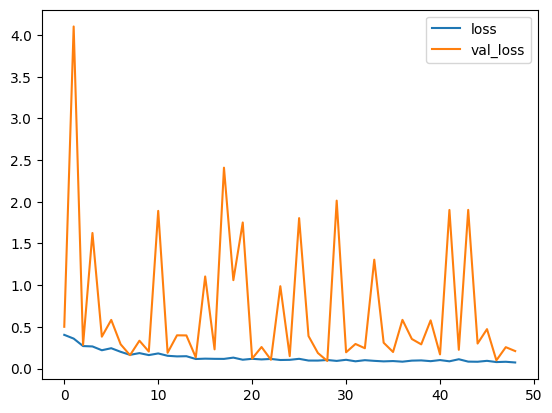

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(len(loss))

plt.plot(x,loss,label='loss')
plt.plot(x,val_loss,label='val_loss')
plt.legend()

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


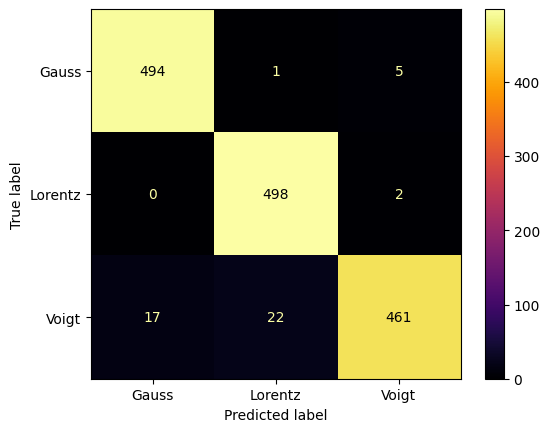

In [9]:
predicoes = model.predict([X_test,statistics_test])

probs = predicoes[0]
predito = np.array(list(map(lambda x: np.argmax(x), probs)))
y = []
for i in y_test:
    y.append(np.argmax(i))

y = np.array(y)
cm = confusion_matrix(y,predito)

cm_d = ConfusionMatrixDisplay(cm, display_labels=['Gauss','Lorentz','Voigt'])
cm_d.plot(cmap='inferno')

In [10]:
print(classification_report(y,predito))
model.evaluate([X_test,statistics_test],y_test)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.96      1.00      0.98       500
           2       0.99      0.92      0.95       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1046 


0.0977664515376091

Text(0, 0.5, 'Larguras Estimadas')

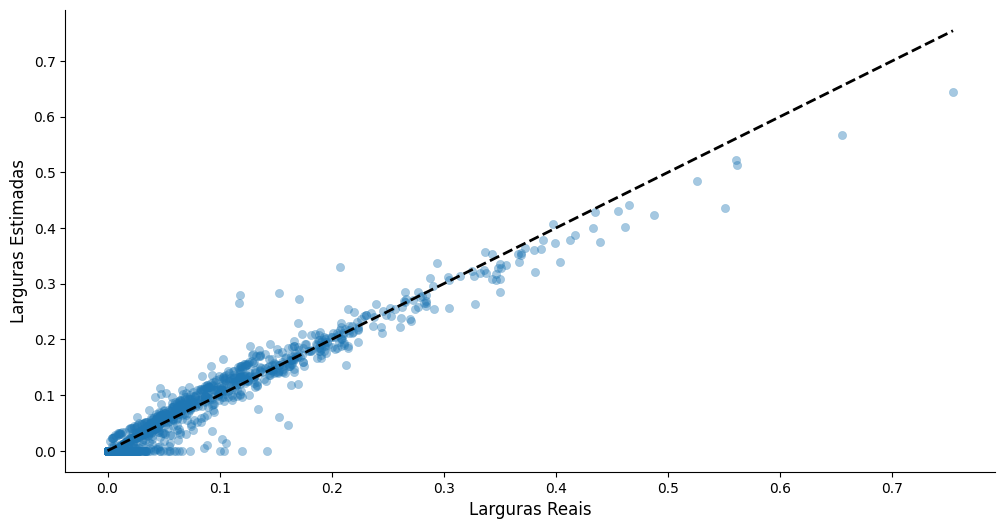

In [11]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
ax.plot([0,np.max(ysigma_test)],[0,np.max(ysigma_test)], color='black',linewidth = 2,linestyle='--')
ax.scatter(x=ysigma_test,y=predicoes[1].reshape(1,-1),alpha= 0.4,linewidths= 0.3)
# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('Larguras Reais',size=12)
plt.ylabel('Larguras Estimadas',size=12)

Text(0, 0.5, 'Larguras Estimadas')

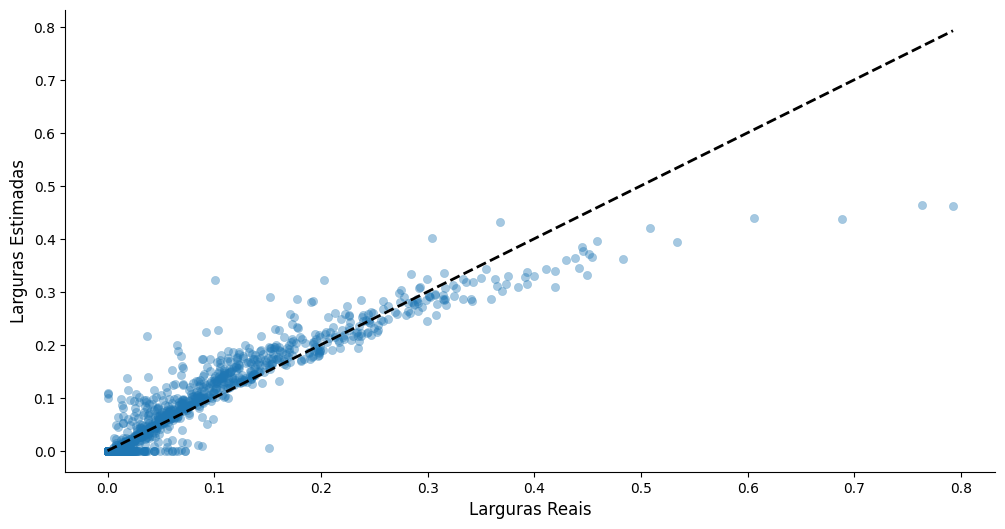

In [12]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
ax.plot([0,np.max(ygamma_test)],[0,np.max(ygamma_test)], color='black',linewidth = 2,linestyle='--')
ax.scatter(x=ygamma_test,y=predicoes[2].reshape(1,-1),alpha= 0.4,linewidths= 0.3)
# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('Larguras Reais',size=12)
plt.ylabel('Larguras Estimadas',size=12)

In [13]:
mean_absolute_error(ysigma_test,predicoes[1])

0.011134356

In [14]:
mean_squared_error(ysigma_test,predicoes[1], squared=False)

0.020366639

In [15]:
mean_absolute_percentage_error(ysigma_test,predicoes[1])

0.25149348

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 50, 3)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 126)   │      5,796 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 13, 126)   │          0 │ conv1d[0][0]      │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 126)   │        504 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 13, 32)    │     40,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 13, 32)    │     10,272 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 13, 32)    │     10,272 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_1 │ (None, 5, 32)     │          0 │ conv1d_3[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32)     │        128 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5, 16)     │      2,576 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5, 16)     │      1,296 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5, 16)     │      1,296 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_2 │ (None, 3, 16)     │          0 │ conv1d_6[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 16)     │         64 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 8)      │        392 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 3, 8)      │        200 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 3, 8)      │        200 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_3 │ (None, 2, 8)      │          0 │ conv1d_9[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 8)      │         32 │ average_pooling1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │     17,408 │ flatten[0][0]   

 Total params: 2,365,701 (9.02 MB)

 Trainable params: 788,437 (3.01 MB)

 Non-trainable params: 388 (1.52 KB)

 Optimizer params: 1,576,876 (6.02 MB)

In [17]:
model.save('(0.1.4)modelo.keras')